<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp2_sample_data_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

In [2]:
class TwoLayerNN(nn.Module):
  def __init__(self, m, d): # fix the second layer to be half 1 and half -1
    super().__init__()
    self.fc1_pos = nn.Linear(d, m, bias=False)
    self.fc1_neg = nn.Linear(d, m, bias=False)
    self.fc2_pos = torch.ones([m, 1])
    self.fc2_neg = -1 * torch.ones([m, 1])


  def activation(self, x): # relu activation
    return x.clamp(min=0)

  def forward(self, x):
    _out_pos = self.activation(self.fc1_pos(x))
    out_pos = torch.matmul(_out_pos, self.fc2_pos)

    _out_neg = self.activation(self.fc1_neg(x))
    out_neg = torch.matmul(_out_neg, self.fc2_neg)

    return out_pos + out_neg

  def init_gaussian(self, init_scales):
    self.fc1_pos.weight.data = init_scales[0] * torch.randn_like(self.fc1_pos.weight)
    self.fc1_neg.weight.data = init_scales[0] * torch.randn_like(self.fc1_neg.weight)

  def features(self, x, normalize=True, scaled=False, n_hidden_to_take=-1):
    x = F.relu(self.fc1_pos(x))+F.relu(self.fc1_neg(x))
    if scaled and n_hidden_to_take in [-1, 3]:
      x = self.fc2(x)
    if normalize:
      x /= (x**2).sum(1, keepdim=True)**0.5
      x[torch.isnan(x)] = 0.0
    return x.data.numpy()

  def feature_sparsity(self, X, n_hidden_to_take=-1, corr_threshold=0.99):
    phi = self.features(X, n_hidden_to_take=n_hidden_to_take)
    idx_keep = np.where((phi > 0.0).sum(0) > 0)[0]
    phi_filtered = phi[:, idx_keep]  # filter out zeros
    corr_matrix = np.corrcoef(phi_filtered.T)
    corr_matrix -= np.eye(corr_matrix.shape[0])

    idx_to_delete, i, j = [], 0, 0
    while i != corr_matrix.shape[0]:
      # print(i, corr_matrix.shape, (np.abs(corr_matrix[i]) > corr_threshold).sum())
      if (np.abs(corr_matrix[i]) > corr_threshold).sum() > 0:
        corr_matrix = np.delete(corr_matrix, (i), axis=0)
        corr_matrix = np.delete(corr_matrix, (i), axis=1)
        # print('delete', j)
        idx_to_delete.append(j)
      else:
        i += 1
      j += 1
    assert corr_matrix.shape[0] == corr_matrix.shape[1]
    # print(idx_to_delete, idx_keep)
    idx_keep = np.delete(idx_keep, [idx_to_delete])
    sparsity = (phi[:, idx_keep] != 0).sum() / (phi.shape[0] * phi.shape[1])

    return sparsity

In [294]:
n_train = 15
n_test = 1000
D_in = 2
D_out = 1
m = 20
m_teacher = 3
l0_threshold_grad_matrix = 0.001
init_scales_teacher= [1.0, 1.0]
seed = 0

def get_data(n, D_in):
  x=torch.randn(n,D_in)
  torch.nn.init.normal_(x, 0, 1) # initialize x

  u=torch.rand(D_in,D_out)
  u=u/u.norm() # ||u||=1
  y=x.mm(u)
  y=y.clamp(min=0)

  return x, y

# new data model
def get_data_two_layer_relu_net(n, d, m_teacher, init_scales_teacher, seed):
    seed = random.randint(1, 100)
    np.random.seed(seed)
    torch.manual_seed(seed)

    n_test = 1000
    H = np.eye(d)
    X = torch.tensor(np.random.multivariate_normal(np.zeros(d), H, n)).float()
    X = X / torch.sum(X**2, 1, keepdim=True)**0.5
    X_test = torch.tensor(np.random.multivariate_normal(np.zeros(d), H, n_test)).float()
    X_test = X_test / torch.sum(X_test**2, 1, keepdim=True)**0.5

    # generate ground truth labels
    with torch.no_grad():
        net_teacher = TwoLayerNN(m_teacher, d)
        # net_teacher.apply(weights_init)
        net_teacher.init_gaussian(init_scales_teacher)
        net_teacher.fc1_pos.weight.data = net_teacher.fc1_pos.weight.data / torch.sum((net_teacher.fc1_pos.weight.data)**2, 1, keepdim=True)**0.5
        net_teacher.fc1_neg.weight.data = net_teacher.fc1_neg.weight.data / torch.sum((net_teacher.fc1_neg.weight.data)**2, 1, keepdim=True)**0.5

        y, y_test = net_teacher(X), net_teacher(X_test)

        print('y', y[:20, 0])

    return X, y, X_test, y_test, net_teacher

In [288]:
x, y, x_test, y_test, net_teacher = get_data_two_layer_relu_net(n_train, D_in, m_teacher, init_scales_teacher, seed)
model =  TwoLayerNN(m, D_in)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=0)
criteria = nn.MSELoss()

y tensor([ 1.8956,  0.9446,  1.9510,  1.1463, -1.8203,  1.3290, -0.7811,  1.0925,
         1.7268,  0.3830, -0.4209, -1.8502, -0.1687, -0.7795,  1.9841])


In [274]:
def weights_init(m):
  for p in m.parameters():
    nn.init.xavier_uniform_(p, gain=.1)

def train(epochs, lr, model):
  train_loss, nets_avg, norm = [], [], []
  net, net_avg = copy.deepcopy(model), copy.deepcopy(model)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0, weight_decay=0)
  net.train()

  for epoch in range(epochs):
    tmp = []
    output = net(x)
    loss = criteria(output, y)
    if epoch % 100 == 0:
      print (epoch, loss.item())
      nets_avg.append(copy.deepcopy(net))
    train_loss += [loss.item()]


    for p in net.parameters():
      tmp += [(p.clone().detach()**2).sum(dim=-1).numpy()]
      break;
    norm += [tmp]

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return train_loss, nets_avg, norm

In [275]:
def compute_grad_matrix(net, X):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0)
    grad_matrix_list = []
    for i in range(X.shape[0]):
        h = net(X[[i]])
        optimizer.zero_grad()
        h.backward()

        grad_total_list = []
        for param in net.parameters():
            grad_total_list.append(param.grad.flatten().data.numpy())

        grad_total = np.concatenate(grad_total_list)
        grad_matrix_list.append(grad_total)

    grad_matrix = np.vstack(grad_matrix_list)
    return grad_matrix

def compute_grad_matrix_ranks(nets, X, l0_threshold_grad_matrix=0.0001):
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X[:n_params]
    grad_matrix_ranks = []
    for net in nets:
        svals = np.linalg.svd(compute_grad_matrix(net, X_eval))[1]
        rank = (svals / svals[0] > l0_threshold_grad_matrix).sum()
        grad_matrix_ranks.append(rank)
    return grad_matrix_ranks

def compute_w_ranks(nets, threshold):
  w_ranks = []
  for net in nets:
    for p in net.parameters():
      svals = np.linalg.svd(p.data.numpy())[1]
      rank = (svals / svals[0] > threshold).sum()
      w_ranks.append(rank)
      break;
  return w_ranks

In [304]:
model = TwoLayerNN(m, D_in)
model.apply(weights_init) # original small initialization

TwoLayerNN(
  (fc1_pos): Linear(in_features=2, out_features=20, bias=False)
  (fc1_neg): Linear(in_features=2, out_features=20, bias=False)
)

In [305]:
lr_small = 0.002
loss_small, net_small, norm_small = train(30000, lr=lr_small, model = model)

0 2.0257749557495117
100 0.05823559686541557
200 0.007728572469204664
300 0.003080374328419566
400 0.002322434913367033
500 0.0020179187413305044
600 0.0018147247610613704
700 0.0016748651396483183
800 0.0015690665459260345
900 0.0014873052714392543
1000 0.0014238186413422227
1100 0.0013714026426896453
1200 0.0013278626138344407
1300 0.0012919686269015074
1400 0.0012628481490537524
1500 0.0012397486716508865
1600 0.001221118145622313
1700 0.0012059755390509963
1800 0.0011930790496990085
1900 0.0011817769845947623
2000 0.0011723091593012214
2100 0.0011644173646345735
2200 0.0011579471174627542
2300 0.0011524826986715198
2400 0.0011478591477498412
2500 0.001143936300650239
2600 0.001140621374361217
2700 0.0011378034250810742
2800 0.001135414931923151
2900 0.001133385463617742
3000 0.0011316535528749228
3100 0.0011301859049126506
3200 0.0011289287358522415
3300 0.0011278589954599738
3400 0.0011269364040344954
3500 0.00112615164835006
3600 0.0011254772543907166
3700 0.0011248963419348001
3

In [307]:
lr_large = 0.2
loss_large, net_large, norm_large = train(30000, lr=lr_large, model = model)

0 2.0257749557495117
100 0.003118368098512292
200 0.0019971299916505814
300 0.001114019425585866
400 0.0006665229448117316
500 0.0004520200891420245
600 0.00027916920953430235
700 0.0001472939329687506
800 9.728698205435649e-05
900 7.435445877490565e-05
1000 6.565059447893873e-05
1100 6.428249616874382e-05
1200 5.1109502237522975e-05
1300 4.161752440268174e-05
1400 3.530234971549362e-05
1500 2.956946445920039e-05
1600 2.6861078367801383e-05
1700 2.27334658120526e-05
1800 1.9830524252029136e-05
1900 1.7443400793126784e-05
2000 1.5631185306119733e-05
2100 1.3470948942995165e-05
2200 1.2062092537235003e-05
2300 1.0551185368967708e-05
2400 9.38616540224757e-06
2500 8.41407472762512e-06
2600 7.408345027215546e-06
2700 6.645595931331627e-06
2800 5.93631693845964e-06
2900 5.306237198965391e-06
3000 4.7269222704926506e-06
3100 4.279621407476952e-06
3200 3.909493898390792e-06
3300 3.526579348545056e-06
3400 3.2268528684653575e-06
3500 3.016353730345145e-06
3600 2.706604618651909e-06
3700 2.4265

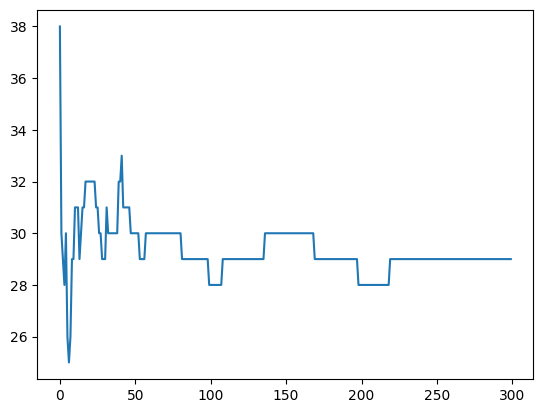

In [308]:
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
grad_matrix_ranks_small = compute_grad_matrix_ranks(net_small, x_test[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks_small)

TwoLayerNN(
  (fc1_pos): Linear(in_features=2, out_features=20, bias=False)
  (fc1_neg): Linear(in_features=2, out_features=20, bias=False)
)


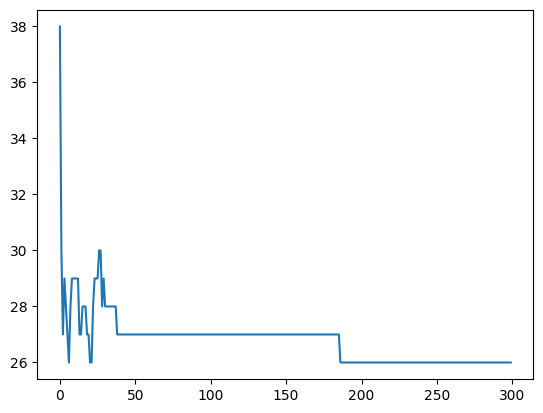

In [309]:
print(net_large[1])
n_params = sum([np.prod(param.shape) for param in net_large[-1].parameters()])
grad_matrix_ranks_large = compute_grad_matrix_ranks(net_large, x_test[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks_large)

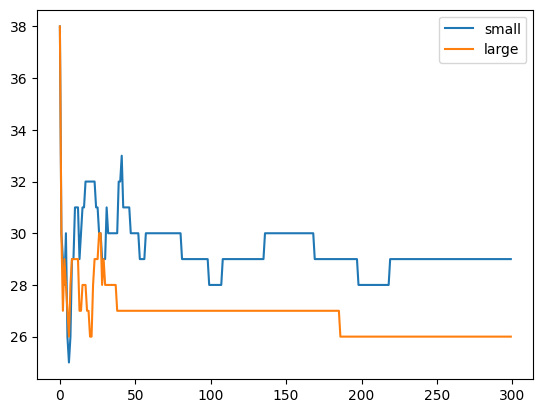

In [311]:
fig,ax = plt.subplots()
plt.plot(grad_matrix_ranks_small, label='small')
plt.plot(grad_matrix_ranks_large, label='large')
ax.legend()

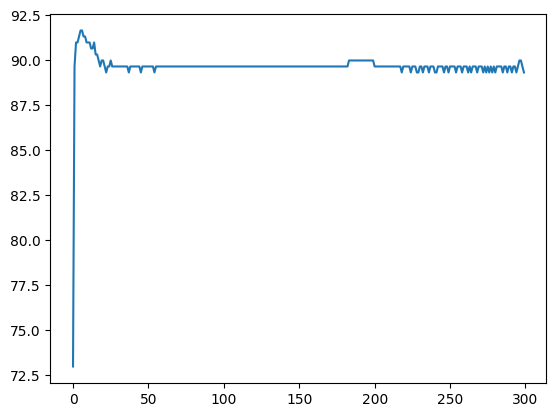

In [310]:
feature_sparsity_small = np.array([net.feature_sparsity(x) for net in net_small])
plt.plot(100*feature_sparsity_small)

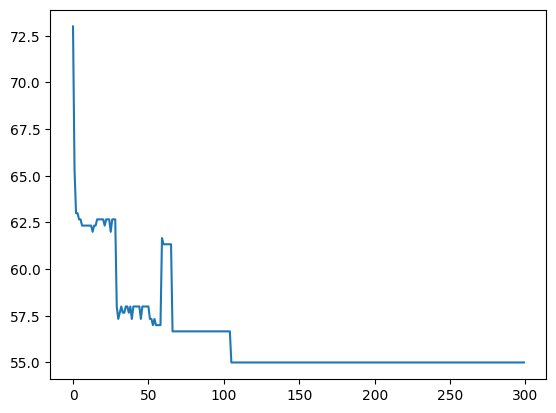

In [312]:
feature_sparsity_large = np.array([net.feature_sparsity(x) for net in net_large])
plt.plot(100*feature_sparsity_large)

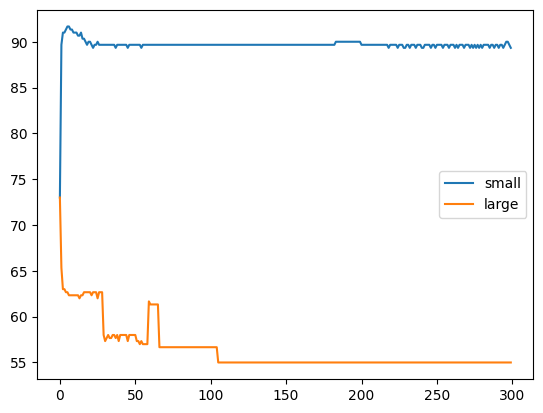

In [313]:
fig,ax = plt.subplots()
plt.plot(100*feature_sparsity_small, label='small')
plt.plot(100*feature_sparsity_large, label='large')
ax.legend()

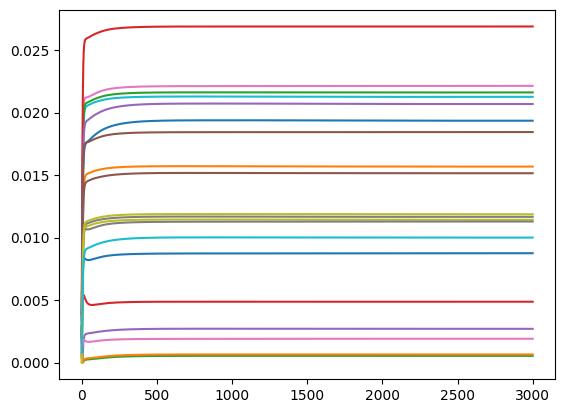

In [314]:
norm_small = np.array(norm_small)
for i in range(m):
  plt.plot(norm_small[::10, 0, i])

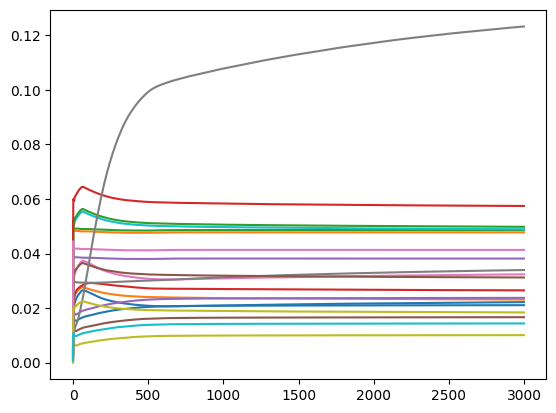

In [315]:
norm_large = np.array(norm_large)
for i in range(m):
  plt.plot(norm_large[::10, 0, i])

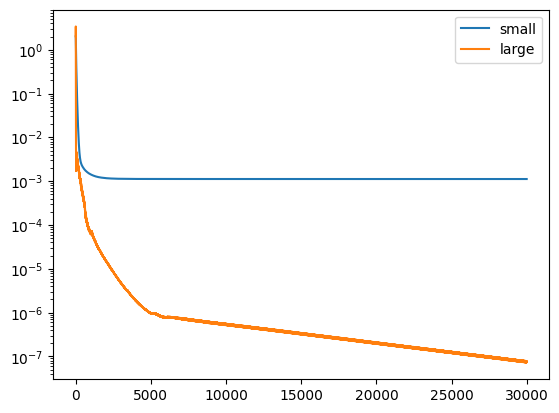

In [316]:
fig,ax = plt.subplots()
plt.yscale('log')
plt.plot(loss_small, label='small')
plt.plot(loss_large, label='large')
ax.legend()